# Aula 2: Análise de Sentimentos usando Bag of Words

Neste notebook iremos treinar um rede de uma única camada para fazer análise de sentimento usando o dataset IMDB.

**A função tokenize foi inspirada no código mostrado em sala de aula.** 

(Notebok da aula 1 do Pedro Gengo: https://colab.research.google.com/drive/1FIG0-2DMgMjPHIYXqeM3M124ahd44Zkq?usp=sharing ) 

In [ ]:
nome = 'Matheus Lindino'
print(f'Meu nome é {nome}')

Meu nome é Matheus Lindino


# Importando as bibliotecas necessárias

In [ ]:
import re
import torch
import numpy as np
import collections
import pandas as pd
import matplotlib.pyplot as plt

from typing import List

# Preparando Dados

Primeiro, fazemos download do dataset:

In [ ]:
!wget -nc http://files.fast.ai/data/examples/imdb_sample.tgz
!tar -xzf imdb_sample.tgz

--2022-08-31 23:53:47--  http://files.fast.ai/data/examples/imdb_sample.tgz
Resolving files.fast.ai (files.fast.ai)... 104.26.3.19, 172.67.69.159, 104.26.2.19, ...
Connecting to files.fast.ai (files.fast.ai)|104.26.3.19|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.fast.ai/data/examples/imdb_sample.tgz [following]
--2022-08-31 23:53:47--  https://files.fast.ai/data/examples/imdb_sample.tgz
Connecting to files.fast.ai (files.fast.ai)|104.26.3.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 571827 (558K) [application/x-gtar-compressed]
Saving to: ‘imdb_sample.tgz’

imdb_sample.tgz     100%[===================>] 558.42K  1.96MB/s    in 0.3s    

2022-08-31 23:53:48 (1.96 MB/s) - ‘imdb_sample.tgz’ saved [571827/571827]



Carregamos o dataset .csv usando o pandas:

In [ ]:
df = pd.read_csv('imdb_sample/texts.csv')
df.shape
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


Iremos agora apenas selecionar 100 exemplos de treinamento:

In [ ]:
treino = df[df['is_valid'] == False]  # Apenas treinamento, isto é, descartamos o dataset de validação.

print('treino.shape original:', treino.shape)

treino = treino[:100]  # Aqui truncamos o dataset para os 100 primeiros exemplos. 

print('treino.shape depois:', treino.shape)

treino.shape original: (800, 3)
treino.shape depois: (100, 3)


Iremos dividir este conjunto em entrada (X) e saída desejada (Y, target) e converter as strings "positive" e "negative" do target para valores booleanos:

In [ ]:
X_treino = treino['text']
Y_treino = treino['label']

print(f'Primeiras linhas de X_treino:\n{X_treino.head()}\n')
print(f'Primeiras linhas de Y_treino:\n{Y_treino.head()}\n')

mapeamento = {'positive': True, 'negative': False}
Y_treino = Y_treino.map(mapeamento)
Y_treino = torch.tensor(Y_treino.values, dtype=torch.long)
print(f'Tamanho de Y_treino: {Y_treino.shape}')
print(f'5 primeiras linhas de Y_treino: {Y_treino[:5]}')
print(f'Número de exemplos positivos: {(Y_treino == True).sum()}')
print(f'Número de exemplos negativos: {(Y_treino == False).sum()}')

Primeiras linhas de X_treino:
0    Un-bleeping-believable! Meg Ryan doesn't even ...
1    This is a extremely well-made film. The acting...
2    Every once in a long while a movie will come a...
3    Name just says it all. I watched this movie wi...
4    This movie succeeds at being one of the most u...
Name: text, dtype: object

Primeiras linhas de Y_treino:
0    negative
1    positive
2    negative
3    positive
4    negative
Name: label, dtype: object

Tamanho de Y_treino: torch.Size([100])
5 primeiras linhas de Y_treino: tensor([0, 1, 0, 1, 0])
Número de exemplos positivos: 51
Número de exemplos negativos: 49


# Definindo o tokenizador

Agora temos a função de tokenização, isto é, que converte strings para tokens.

In [ ]:
def tokenize(text: str):
  """
  Convert string to a list of tokens (i.e., words).
  This function lower cases everything and removes punctuation.
  """
  
  pattern = r'\w+'
  upper_tokens = re.findall(pattern, text)
  tokenized = [tokens.lower() for tokens in upper_tokens]
  return tokenized

## Testando a função com um exemplo simples


In [ ]:
assert tokenize("I like to eat pizza.") == ['i', 'like', 'to', 'eat', 'pizza'], "Não passou no assert."
print('Passou no assert!')

Passou no assert!


# Definindo o vocabulário

Selecionaremos os `max_tokens` (ex: 1000) tokens mais frequentes do dataset de treino como sendo nosso vocabulário.

In [ ]:
def create_vocab(texts: List[str], max_tokens: int):
  """
  Returns a dictionary whose keys are tokens and values are token ids (from 0 to max_tokens - 1).
  """

  tokens = tokenize(' '.join(texts))
  counter = collections.Counter(tokens).most_common(max_tokens)
  
  vocab = dict((key, i) for i, (key, values) in enumerate(counter))
  return vocab

## Testando a função


In [ ]:
text = ['Apple Banana Orange Mango', 'Apple Apple Orange Banana', 'Apple Banana']
n_tokens = 4
vocab = create_vocab(text, n_tokens)

assert len(vocab) == n_tokens, 'Number of elements incorrect'
assert ('apple', 0) in vocab.items(), 'First element incorrect'

print('Passou no assert!')

Passou no assert!


# Função para converter string para Bag-of-words

In [ ]:
def convert_to_bow(text: str, vocab):
  """
  Returns a bag-of-word vector of size len(vocab).
  """

  tokens = tokenize(text)
  bow = torch.zeros(len(vocab))
  
  for sample in tokens:
    if sample in vocab:
      bow[vocab[sample]] = 1

  return bow

## Testando a função

In [ ]:
text = ['Apple Banana Orange Mango', 'Apple Apple Orange Banana', 'Apple Banana']
n_tokens = 6
vocab = create_vocab(text, n_tokens)
bow = []

for sample in text:
  bow.append(convert_to_bow(sample, vocab))

assert len(bow[0]) == len(vocab), 'Number of elements incorrect'
assert len(bow) == len(text), 'Number of samples incorrect'

print('Passou no assert!')

Passou no assert!


## Definindo a Rede Neural

**Entrada:**

$x \in R^{B \times |V|}$     (bag-of-words)

**Parametros:**

$W \in R^{|V| \times K}$    (weights: matriz de pesos)

$b \in R^{K}$    (bias/viés)

**Saída:**

$p \in R^{B \times K}$  (probabilidade de cada classe)


**Onde:**

$K$ = número de classes

$B$ = tamanho do batch

$|V|$ = tamanho do vocabulário

**Definição da rede:**

$z = xW + b$   (camada linear. $z$ é chamado de logits)

$p_i = \frac{e^{z_i}}{\sum_{j=0}^{K-1} e^{z_j}}$   (softmax)



In [ ]:
def softmax(logits):
  logits_max = torch.max(logits, dim=1, keepdim=True)[0]
  logits_exp = torch.exp(logits - logits_max)
  return logits_exp/torch.sum(logits_exp, dim=1, keepdim=True)

class MyModel():
  
  def __init__(self, dim: int, n_classes: int):
    self.weights = 0.01 * torch.rand(dim, n_classes) - 0.005
    self.bias = 0.01 * torch.rand(n_classes) - 0.005
    
    self.weights.requires_grad = True
    self.bias.requires_grad = True

  def __call__(self, x):
    logits = torch.matmul(x, self.weights) + self.bias
    probs = softmax(logits)
    return probs

## Testando modelo com uma entrada aleatória

Escreva abaixo um pequeno código para testar se seu modelo processa uma matriz de entrada de tamanho `batch_size, dim`, ou seja, a matriz contém `batch_size` exemplos, cada um sendo representado por um vetor de tamanho `dim`.

In [ ]:
batch_size = 10
dim = 100
n_classes = 2

X = torch.rand(batch_size, dim)
model = MyModel(dim=dim, n_classes=n_classes)
probs = model(X)

assert probs.shape == (X.shape[0], n_classes), 'Dimension incorrect'
assert probs.sum(1)[0] == 1., 'Softmax incorrect' 
print('Passou no assert')

Passou no assert


# Função de custo Entropia Cruzada

$y \in R^{K}$  (target),

a equação da entropia cruzada associada a um exemplo é dada por:

$L = \sum_{i=0}^{K-1} -y_i \log p_i$   (esta é a loss por exemplo)

Se $y$ for um vetor one-hot (apenas um dos elementos é diferente de zero), podemos simplicar a equação acima para:

$L = -\log p_i$

Onde $i$ é o indice da classe correta. Ou seja, $p_i$ é a probabilidade que o modelo colocou na classe correta.

A função de custo é a **média** da entropia cruzada de cada exemplo no batch.

In [ ]:
def cross_entropy_loss(probs, targets):
    """
    Args:
      probs: a float32 matrix of shape (batch_size, number of classes)
      targets: a long (int64) array of shape (batch_size)

    Returns:
      Mean loss in the batch.
    """
    
    range = torch.arange(0, len(targets))
    losses = -torch.log(probs[range, targets[range]])

    return losses.mean()

## Testando a função entropia cruzada com probabilidades de 50%

Escreva abaixo um pequeno código para testar se a entropia cruzada confere com a resposta do problema 3.6 do exercício da semana passada. Crie um tensor para as probabilidades (50%) e um target também aleatório balanceado e calcule a cross entropia. Qual é o valor esperado da cross entropia nesse caso?

In [ ]:
from math import log 

probs = torch.tensor([[.5, .5], [.5, .5], [.5, .5], [.5, .5], [.5, .5], [.5, .5], [.5, .5], [.5, .5], [.5, .5], [.5, .5]])
targets = torch.tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

assert cross_entropy_loss(probs, targets) == log(2), 'Cross Entropy incorrect'
print('Passou no assert')

Passou no assert


# Convertendo dataset de treino para uma matriz de bag-of-words

In [ ]:
vocab = create_vocab(X_treino, max_tokens=1000)
bows = []
for text in X_treino:
    bow = convert_to_bow(text, vocab)
    bows.append(bow)

X = torch.stack(bows)
print(X.shape)

torch.Size([100, 1000])


# Laço de Treinamento

In [ ]:
num_iterations = 100
learning_rate = 0.1
n_classes = 2
losses = []

model = MyModel(dim=len(vocab), n_classes=n_classes)

for i in range(num_iterations):
    # Zera os gradientes
    if model.weights.grad is not None:
        model.weights.grad.data.zero_()
        model.bias.grad.data.zero_()

    probs = model(X)
    loss = cross_entropy_loss(probs, Y_treino)
    print(f'iteration: {i}  loss: {loss:.6f}  exp(loss): {torch.exp(loss):.4f}')
    losses.append(loss.item())
    loss.backward()

    #Atualiza os pesos
    model.weights.data = model.weights.data - learning_rate * model.weights.grad.data
    model.bias.data = model.bias.data - learning_rate * model.bias.grad.data

iteration: 0  loss: 0.693480  exp(loss): 2.0007
iteration: 1  loss: 0.650483  exp(loss): 1.9165
iteration: 2  loss: 0.612096  exp(loss): 1.8443
iteration: 3  loss: 0.577708  exp(loss): 1.7819
iteration: 4  loss: 0.546790  exp(loss): 1.7277
iteration: 5  loss: 0.518886  exp(loss): 1.6802
iteration: 6  loss: 0.493604  exp(loss): 1.6382
iteration: 7  loss: 0.470608  exp(loss): 1.6010
iteration: 8  loss: 0.449615  exp(loss): 1.5677
iteration: 9  loss: 0.430380  exp(loss): 1.5378
iteration: 10  loss: 0.412695  exp(loss): 1.5109
iteration: 11  loss: 0.396382  exp(loss): 1.4864
iteration: 12  loss: 0.381289  exp(loss): 1.4642
iteration: 13  loss: 0.367284  exp(loss): 1.4438
iteration: 14  loss: 0.354254  exp(loss): 1.4251
iteration: 15  loss: 0.342100  exp(loss): 1.4079
iteration: 16  loss: 0.330736  exp(loss): 1.3920
iteration: 17  loss: 0.320087  exp(loss): 1.3772
iteration: 18  loss: 0.310088  exp(loss): 1.3635
iteration: 19  loss: 0.300679  exp(loss): 1.3508
iteration: 20  loss: 0.291810 

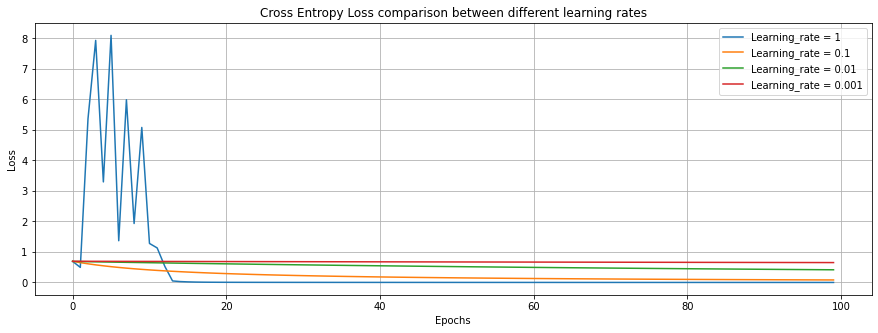

In [ ]:
num_iterations = 100
learning_rate = [1, 0.1, 0.01, 0.001]
n_classes = 2
final_loss = []

plt.figure(figsize=(15,5))

for lr in learning_rate:    
  losses = []
  model = MyModel(dim=len(vocab), n_classes=n_classes)

  for i in range(num_iterations):
    if model.weights.grad is not None:
        model.weights.grad.data.zero_()
        model.bias.grad.data.zero_()

    probs = model(X)
    loss = cross_entropy_loss(probs, Y_treino)
    losses.append(loss.item())
    loss.backward()

    model.weights.data = model.weights.data - lr * model.weights.grad.data
    model.bias.data = model.bias.data - lr * model.bias.grad.data

  plt.plot(losses, label=f'Learning_rate = {lr}')
  final_loss.append(losses[-1])

plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.title('Cross Entropy Loss comparison between different learning rates')
plt.legend(); plt.grid(); plt.show()

In [ ]:
RESET = "\033[0;0m"
BOLD    = "\033[;1m"

print(f'{BOLD}Final Losses after 100 epochs:{RESET}')
for i in range(len(final_loss)): print(f'\tLearning_rate = {learning_rate[i]}\t ----- \tLoss = {round(final_loss[i],3)}')

Final Losses after 100 epochs:
	Learning_rate = 1	 ----- 	Loss = 0.002
	Learning_rate = 0.1	 ----- 	Loss = 0.084
	Learning_rate = 0.01	 ----- 	Loss = 0.417
	Learning_rate = 0.001	 ----- 	Loss = 0.653


Sobre os resultados do learning rate, é necessário destacar dois pontos:


*   Mesmo que o valor de loss de treinamento seja menor quando o learning rate é maior, não quer dizer que esse modelo generalizou melhor que os demais. Apenas que ele convergiu mais rapidamente.

*   Com o learning rate igual a 1, é possível visualizar uma mudança drástica no começo. Isso se dá pelo passo que o gradiente realiza ser muito alto, ocasionado nesses saltos. Nesse exercício, mesmo com esses saltos, o modelo conseguiu convergir para um ponto ótimo. Isso nem sempre é verdade.

